#### * _We used Pytorch for our CNN models_ *

# __Why Detect Lane Markings__
For our project, we are interested in working on lane detection for autonomous vehicles using lane markings painted on the roads. The task of lane detection is still vital to the success of autonomous vehicles because it is pertinent that an autonomous vehicle can exactly recognize which lane it is in and where it needs to go. If it is not able to do that, the vehicles might be going in the middle of two lanes which can be dangerous for other vehicles in the vicinity. Also, lane detection is inevitable to perform maneuvers like lane changes and also for predicting other vehicles’ behavior.

# __Build a lane extractor from an image__
In this project, we tried to train a Convolutional Neural Network (CNN) to extract lane markings as features from given images of roads with lanes. 

### __Dataset Description__
We plan on using the __CULane Dataset__ (Chinese University Lane Dataset) which contains 88,880 images for the training set, 9,675 images for the validation set and 34,680 images for the test set. Furthermore, the test set is divided into one normal and 8 challenging categories that tests the network on harder images. The dataset is desirable because it contains images from a variety of settings like crowded, night, no line, shadow, curve, etc. Such diversity in the dataset is desirable for training the model.	

### __Modelling Pipeline__
  1. Extract the images from the dataset stored on Drive
  2. Organize the images into raw images and labelled value
  3. Train the Model
  4. Get a reasonable validation accuracy
  5. Test the Model on unseen images 

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
CODE = 'My Drive/cs231n/Project/LaneNet'       # path to our code on Drive
DATASET = 'My Drive/cs231n/Project/dataset/trainset'
EXPERIMENT = 'My Drive/cs231n/Project/LaneNet/config'
MODEL_SAVE = 'My Drive/cs231n/Project'
PRETRAINED = 'My Drive/cs231n/Project/pretrained'

CODE_PATH = join(ROOT, CODE)
DATASET_PATH = join(ROOT, DATASET)
EXPERIMENT_CONFIG = join(ROOT, EXPERIMENT)
MODEL_SAVE = join(ROOT, MODEL_SAVE)
PRETRAINED_PATH = join(ROOT, PRETRAINED)

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('{}'.format(CODE_PATH))



Mounted at /content/drive


## Some Imports


In [0]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### Let's visualize some of the images we have
We have a contiguous set of 20 images frame-by-frame for each scene, with the 20th frame labelled in our dataset. <br>
Let's visualize these images to understand what each scene information contains:


In [0]:
# Obtaining a list of paths for each image
"""
FIXED_PATH = DATASET_PATH + '/clips/0313-1/60/'
items = os.listdir(FIXED_PATH)
n_images = len(items)
plt_idx = 0
fig = plt.figure()
n_cols = 20
for image in items: 
  plt_idx += 1
  full_path = FIXED_PATH + image
  a = fig.add_subplot(n_cols, np.ceil(n_images/float(n_cols)), plt_idx)
  img = plt.imread(full_path)
  #plt.imshow(img.astype('uint8'))
fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()
"""

"\nFIXED_PATH = DATASET_PATH + '/clips/0313-1/60/'\nitems = os.listdir(FIXED_PATH)\nn_images = len(items)\nplt_idx = 0\nfig = plt.figure()\nn_cols = 20\nfor image in items: \n  plt_idx += 1\n  full_path = FIXED_PATH + image\n  a = fig.add_subplot(n_cols, np.ceil(n_images/float(n_cols)), plt_idx)\n  img = plt.imread(full_path)\n  #plt.imshow(img.astype('uint8'))\nfig.set_size_inches(np.array(fig.get_size_inches()) * n_images)\nplt.show()\n"

# __1. Extract the images from the dataset stored on Drive__ 

We have already done so in our Operational.ipynb notebook
<br>

## Some imports for the modules

In [0]:
import argparse
import json
import os
import shutil
import time

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

#from config import *
import data
from model import SCNN
from utils.tensorboard import TensorBoard
from utils.transforms import *
from utils.lr_scheduler import PolyLR

## Loading model configurations

In [4]:
# Location of our configuration for training
exp_dir = EXPERIMENT_CONFIG + '/cfg.json'
exp_name = '0'
save_dir = MODEL_SAVE + '/' + exp_name
with open(exp_dir) as f:
  exp_cfg = json.load(f)
print(exp_cfg)

# Extracting important configurations
resize_shape = tuple(exp_cfg['dataset']['resize_shape'])

device = torch.device(exp_cfg['device'])

######################## COMMAND CENTER LATER###############
#tensorboard = TensorBoard(exp_dir) # Command center Later
############################################################

{'device': 'cuda:0', 'MAX_EPOCHES': 10, 'dataset': {'dataset_name': 'Tusimple', 'batch_size': 32, 'resize_shape': [512, 288]}, 'optim': {'lr': 0.15, 'momentum': 0.9, 'weight_decay': 0.0001, 'nesterov': True}, 'lr_scheduler': {'warmup': 20, 'max_iter': 1500, 'min_lrs': 1e-10}, 'model': {'scale_exist': 0.07}}


# __2. Organize the images into raw images and labelled value__

Here, we will generate labelled data for our train, validation and test splits. We will generate labelled data as bindary masks since the original dataset doesn't come preloaded with this information.
<br>
Moreover, instead of loading data manually, we decided on using Pytorch to create a custom Dataset and DataLoader
<br> 
More details on the DataLoader setup can be found in `LaneNet/Data/Tusimple.py`


### Data Pre-processing
We perform three data augmentation steps to our images:
<br>
1. Resizing images to make them smaller
2. Rotation by 2 degrees
3. Normalizing data by given mean and standard deviation


In [0]:
# Training data
# Predefined mean and std- deviation
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

transform_train = Compose(Resize(resize_shape), Rotation(2), ToTensor(),
                          Normalize(mean=mean, std=std))

### Now we perform data loading operations on our custom defined Dataset Object `namely Tusimple`
Basically, this is where we create our __train, validation and test splits__ on our dataset

In [6]:
dataset_name = exp_cfg['dataset']['dataset_name']
Dataset_Type = getattr(data, dataset_name)

# Training Data
train_dataset = Dataset_Type("", "train", transform_train)
train_loader = DataLoader(train_dataset, batch_size=exp_cfg['dataset']['batch_size'], shuffle=True, collate_fn=train_dataset.collate, num_workers=8)

# Validation Data
transform_val_img = Resize(resize_shape)
transform_val_x = Compose(ToTensor(), Normalize(mean=mean, std=std))
transform_val = Compose(transform_val_img, transform_val_x)
val_dataset = Dataset_Type("", "val", transform_val)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=val_dataset.collate, num_workers=4)

Label is going to get generated into dir: seg_label ...
/content/drive/My Drive/cs231n/Project/dataset/trainset/seg_label
train set is done
val set is done
test set is done
Label is going to get generated into dir: seg_label ...
/content/drive/My Drive/cs231n/Project/dataset/trainset/seg_label
train set is done
val set is done
test set is done


## Initializing our Neural Network Model


In [0]:
net = SCNN(resize_shape, pretrained=True)
net = net.to(device)
net = torch.nn.DataParallel(net)

optimizer = optim.SGD(net.parameters(), **exp_cfg['optim'])
lr_scheduler = PolyLR(optimizer, 0.9, **exp_cfg['lr_scheduler'])
best_val_loss = 1e6

### Understanding the Data Loader

Let's see what's there in the DataLoader

In [9]:
"""
from utils.prob2lines import getLane

net.train()
train_loss = 0
train_loss_seg = 0
train_loss_exist = 0 
for batch_idx, sample in enumerate(val_loader):
  img = sample['img'].to(device)
  segLabel = sample['segLabel'].to(device)
  exist = sample['exist'].to(device)
  break
print(sample['segLabel'])
optimizer.zero_grad()
seg_pred, exist_pred = net(img)[:2]
seg_pred = F.softmax(seg_pred, dim=1)
seg_pred = seg_pred.detach().cpu().numpy()
exist_pred = exist_pred.detach().cpu().numpy()

for b in range(len(seg_pred)):
  seg = seg_pred[b]
  exist = [1 if exist_pred[b, i] > 0.5 else 0 for i in range(4)]
  pred_lane_coords = getLane.prob2lines_tusimple(seg, exist, resize_shape=(720, 1280), y_px_gap=10, pts=56)
  for i in range(len(lane_coords)):
      lane_coords[i] = sorted(lane_coords[i], key=lambda pair: pair[1])


  for l in lane_coords:
      if len(l) == 0:
          continue
      json_dict['lanes'].append([])
      for (x, y) in l:
          json_dict['lanes'][-1].append(int(x))
  for (x, y) in lane_coords[0]:
      json_dict['h_sample'].append(y)
  dump_to_json.append(json.dumps(json_dict))
"""

"\nfrom utils.prob2lines import getLane\n\nnet.train()\ntrain_loss = 0\ntrain_loss_seg = 0\ntrain_loss_exist = 0 \nfor batch_idx, sample in enumerate(val_loader):\n  img = sample['img'].to(device)\n  segLabel = sample['segLabel'].to(device)\n  exist = sample['exist'].to(device)\n  break\nprint(sample['segLabel'])\noptimizer.zero_grad()\nseg_pred, exist_pred = net(img)[:2]\nseg_pred = F.softmax(seg_pred, dim=1)\nseg_pred = seg_pred.detach().cpu().numpy()\nexist_pred = exist_pred.detach().cpu().numpy()\n\nfor b in range(len(seg_pred)):\n  seg = seg_pred[b]\n  exist = [1 if exist_pred[b, i] > 0.5 else 0 for i in range(4)]\n  pred_lane_coords = getLane.prob2lines_tusimple(seg, exist, resize_shape=(720, 1280), y_px_gap=10, pts=56)\n  for i in range(len(lane_coords)):\n      lane_coords[i] = sorted(lane_coords[i], key=lambda pair: pair[1])\n\n\n  for l in lane_coords:\n      if len(l) == 0:\n          continue\n      json_dict['lanes'].append([])\n      for (x, y) in l:\n          json_dict[

## Defining our train function

In [0]:
def train(epoch, train_loss_history):
    print("Train Epoch: {}".format(epoch))
    net.train()
    train_loss = 0
    train_loss_seg = 0
    train_loss_exist = 0
    progressbar = tqdm(range(len(train_loader)))

    for batch_idx, sample in enumerate(train_loader):
        img = sample['img'].to(device)
        segLabel = sample['segLabel'].to(device)
        exist = sample['exist'].to(device)

        optimizer.zero_grad()
        seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist)
        if isinstance(net, torch.nn.DataParallel):
            loss_seg = loss_seg.sum()
            loss_exist = loss_exist.sum()
            loss = loss.sum()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        iter_idx = epoch * len(train_loader) + batch_idx
        train_loss = loss.item()
        train_loss_seg = loss_seg.item()
        train_loss_exist = loss_exist.item()
        progressbar.set_description("batch loss: {:.3f}".format(loss.item()))
        progressbar.update(1)

        train_loss_history.append(train_loss)
        lr = optimizer.param_groups[0]['lr']
        
        # Command center later
        #tensorboard.scalar_summary(exp_name + "/train_loss", train_loss, iter_idx)
        #tensorboard.scalar_summary(exp_name + "/train_loss_seg", train_loss_seg, iter_idx)
        #tensorboard.scalar_summary(exp_name + "/train_loss_exist", train_loss_exist, iter_idx)
        #tensorboard.scalar_summary(exp_name + "/learning_rate", lr, iter_idx)

    progressbar.close()
    #tensorboard.writer.flush()

    if epoch % 1 == 0:
        save_dict = {
            "epoch": epoch,
            "net": net.module.state_dict() if isinstance(net, torch.nn.DataParallel) else net.state_dict(),
            "optim": optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "best_val_loss": best_val_loss
        }
        
        if not os.path.exists(save_dir):
          os.makedirs(save_dir)
        save_name = os.path.join(save_dir, exp_name + '.pth')
        torch.save(save_dict, save_name)
        print("model is saved: {}".format(save_name))

    print("------------------------\n")

## Defining our validation function




In [0]:
def val(epoch, validation_loss_history):
    global best_val_loss

    print("Val Epoch: {}".format(epoch))

    net.eval()
    val_loss = 0
    val_loss_seg = 0
    val_loss_exist = 0
    progressbar = tqdm(range(len(val_loader)))

    with torch.no_grad():
        for batch_idx, sample in enumerate(val_loader):
            img = sample['img'].to(device)
            segLabel = sample['segLabel'].to(device)
            exist = sample['exist'].to(device)

            seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist)
            

            if isinstance(net, torch.nn.DataParallel):
                loss_seg = loss_seg.sum()
                loss_exist = loss_exist.sum()
                loss = loss.sum()

            # visualize validation every 5 frame, 50 frames in all
            gap_num = 5
            if batch_idx%gap_num == 0 and batch_idx < 50 * gap_num:
                origin_imgs = []
                seg_pred = seg_pred.detach().cpu().numpy()
                exist_pred = exist_pred.detach().cpu().numpy()

                for b in range(len(img)):
                    img_name = sample['img_name'][b]
                    img = cv2.imread(img_name)
                    img = transform_val_img({'img': img})['img']

                    lane_img = np.zeros_like(img)
                    color = np.array([[255, 125, 0], [0, 255, 0], [0, 0, 255], [0, 255, 255]], dtype='uint8')

                    coord_mask = np.argmax(seg_pred[b], axis=0)
                    for i in range(0, 4):
                        if exist_pred[b, i] > 0.5:
                            lane_img[coord_mask==(i+1)] = color[i]
                    img = cv2.addWeighted(src1=lane_img, alpha=0.8, src2=img, beta=1., gamma=0.)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    lane_img = cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB)
                    cv2.putText(lane_img, "{}".format([1 if exist_pred[b, i]>0.5 else 0 for i in range(4)]), (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 255), 2)
                    origin_imgs.append(img)
                    origin_imgs.append(lane_img)
                #tensorboard.image_summary("img_{}".format(batch_idx), origin_imgs, epoch)
            
            val_loss_history.append(loss.item())
            val_loss += loss.item()
            val_loss_seg += loss_seg.item()
            val_loss_exist += loss_exist.item()

            progressbar.set_description("batch loss: {:.3f}".format(loss.item()))
            progressbar.update(1)

    progressbar.close()
    iter_idx = (epoch + 1) * len(train_loader)  # keep align with training process iter_idx
    #tensorboard.scalar_summary("val_loss", val_loss, iter_idx)
    #tensorboard.scalar_summary("val_loss_seg", val_loss_seg, iter_idx)
    #tensorboard.scalar_summary("val_loss_exist", val_loss_exist, iter_idx)
    #tensorboard.writer.flush()

    print("------------------------\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #if not os.path.exists(save_dir):
        #  os.makedirs(save_dir)
        save_name = os.path.join(save_dir, exp_name + '.pth')
        copy_name = os.path.join(save_dir, exp_name + '_best.pth')
        shutil.copyfile(save_name, copy_name)

# __3. Train our Model__

Finally, we get to train our model on the images

In [20]:
# Let's start training
start_epoch = 0

train_loss_history = []
val_loss_history = []
#exp_cfg['MAX_EPOCHES'] = int(np.ceil(exp_cfg['lr_scheduler']['max_iter'] / len(train_loader)))
for epoch in range(start_epoch, exp_cfg['MAX_EPOCHES']):
    train(epoch, train_loss_history)
    if epoch % 1 == 0:
        print("\nValidation For Experiment: ", exp_dir)
        print(time.strftime('%H:%M:%S', time.localtime()))
        val(epoch, val_loss_history)


  0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch: 0



batch loss: 0.101: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:12
Val Epoch: 0



batch loss: 0.675: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 1



batch loss: 0.087: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:15
Val Epoch: 1



batch loss: 0.867: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 2



batch loss: 0.083: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:18
Val Epoch: 2



batch loss: 0.638: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 3



batch loss: 0.113: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:21
Val Epoch: 3



batch loss: 1.139: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 4



batch loss: 0.203: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:25
Val Epoch: 4



batch loss: 0.793: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 5



batch loss: 0.300: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:28
Val Epoch: 5



batch loss: 0.907: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 6



batch loss: 0.236: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:31
Val Epoch: 6



batch loss: 0.825: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 7



batch loss: 0.117: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:34
Val Epoch: 7



batch loss: 0.830: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 8



batch loss: 0.102: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:37
Val Epoch: 8



batch loss: 0.824: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------

Train Epoch: 9



batch loss: 0.115: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model is saved: /content/drive/My Drive/cs231n/Project/0/0.pth
------------------------


Validation For Experiment:  /content/drive/My Drive/cs231n/Project/LaneNet/config/cfg.json
09:28:40
Val Epoch: 9



batch loss: 0.784: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

------------------------



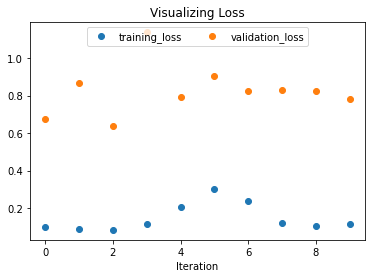

In [23]:
# Visualizing the loss
#print(train_loss_history)
#print(val_loss_history)

plt.title('Visualizing Loss')
plt.plot(train_loss_history, 'o', label="training_loss")
plt.plot(val_loss_history, 'o', label="validation_loss")
plt.xlabel('Iteration')
plt.legend(loc='upper center', ncol=4)
plt.show()

# __5. Test our Model on unseen images__

Let's finally test our model

In [24]:
import argparse
import json
import os

import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import data
from model import SCNN
from utils.prob2lines import getLane
from utils.transforms import *

# Location of our configuration for training
exp_dir = EXPERIMENT_CONFIG + '/cfg.json'
exp_name = '0'
save_dir = MODEL_SAVE + '/' + exp_name
with open(exp_dir) as f:
  exp_cfg = json.load(f)
print(exp_cfg)

def split_path(path):
    """split path tree into list"""
    folders = []
    while True:
        path, folder = os.path.split(path)
        if folder != "":
            folders.insert(0, folder)
        else:
            if path != "":
                folders.insert(0, path)
            break
    return folders

# Extracting important configurations
resize_shape = tuple(exp_cfg['dataset']['resize_shape'])

device = torch.device(exp_cfg['device'])

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = Compose(Resize(resize_shape), ToTensor(),
                    Normalize(mean=mean, std=std))


dataset_name = exp_cfg['dataset']['dataset_name']
Dataset_Type = getattr(data, dataset_name)

# Test Data
test_dataset = Dataset_Type("", "test", transform)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=test_dataset.collate, num_workers=4)

net = SCNN(input_size=resize_shape, pretrained=False)
save_name = os.path.join(save_dir, exp_name + '_best.pth')
save_dict = torch.load(save_name, map_location='cpu')
print("\nloading", save_name, "...... From Epoch: ", save_dict['epoch'])
net.load_state_dict(save_dict['net'])
net = torch.nn.DataParallel(net.to(device))
net.eval()

# ------------ test ------------
out_path = os.path.join(save_dir, "coord_output")
evaluation_path = os.path.join(save_dir, "evaluate")
if not os.path.exists(out_path):
    os.mkdir(out_path)
if not os.path.exists(evaluation_path):
    os.mkdir(evaluation_path)
dump_to_json = []

progressbar = tqdm(range(len(test_loader)))
with torch.no_grad():
    for batch_idx, sample in enumerate(test_loader):
        img = sample['img'].to(device)
        img_name = sample['img_name']

        seg_pred, exist_pred = net(img)[:2]
        seg_pred = F.softmax(seg_pred, dim=1)
        seg_pred = seg_pred.detach().cpu().numpy()
        exist_pred = exist_pred.detach().cpu().numpy()

        for b in range(len(seg_pred)):
            seg = seg_pred[b]
            exist = [1 if exist_pred[b, i] > 0.5 else 0 for i in range(4)]
            lane_coords = getLane.prob2lines_tusimple(seg, exist, resize_shape=(720, 1280), y_px_gap=10, pts=56)
            for i in range(len(lane_coords)):
                lane_coords[i] = sorted(lane_coords[i], key=lambda pair: pair[1])

            path_tree = split_path(img_name[b])
            save_dir, save_name = path_tree[-3:-1], path_tree[-1]
            save_dir = os.path.join(out_path, *save_dir)
            save_name = save_name[:-3] + "lines.txt"
            save_name = os.path.join(save_dir, save_name)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir, exist_ok=True)

            with open(save_name, "w") as f:
                for l in lane_coords:
                    for (x, y) in l:
                        print("{} {}".format(x, y), end=" ", file=f)
                    print(file=f)

            json_dict = {}
            json_dict['lanes'] = []
            json_dict['h_sample'] = []
            json_dict['raw_file'] = os.path.join(*path_tree[-4:])
            json_dict['run_time'] = 0
            for l in lane_coords:
                if len(l) == 0:
                    continue
                json_dict['lanes'].append([])
                for (x, y) in l:
                    json_dict['lanes'][-1].append(int(x))
            for (x, y) in lane_coords[0]:
                json_dict['h_sample'].append(y)
            dump_to_json.append(json.dumps(json_dict))

        progressbar.update(1)
progressbar.close()

with open(os.path.join(out_path, "predict_test.json"), "w") as f:
    for line in dump_to_json:
        print(line, end="\n", file=f)

# ---- evaluate ----
from utils.lane_evaluation.tusimple.lane import LaneEval

print(save_dir)

eval_result = LaneEval.bench_one_submit(os.path.join(out_path, "predict_test.json"),
                                        DATASET_PATH + "/label_0601.json")
print(eval_result)
with open(os.path.join(evaluation_path, "evaluation_result.txt"), "w") as f:
    print(eval_result, file=f)

{'device': 'cuda:0', 'MAX_EPOCHES': 10, 'dataset': {'dataset_name': 'Tusimple', 'batch_size': 32, 'resize_shape': [512, 288]}, 'optim': {'lr': 0.15, 'momentum': 0.9, 'weight_decay': 0.0001, 'nesterov': True}, 'lr_scheduler': {'warmup': 20, 'max_iter': 1500, 'min_lrs': 1e-10}, 'model': {'scale_exist': 0.07}}
Label is going to get generated into dir: seg_label ...
/content/drive/My Drive/cs231n/Project/dataset/trainset/seg_label
train set is done
val set is done
test set is done



  0%|          | 0/1 [00:00<?, ?it/s]


loading /content/drive/My Drive/cs231n/Project/0/0_best.pth ...... From Epoch:  3



100%|██████████| 1/1 [00:11<00:00, 11.12s/it]


/content/drive/My Drive/cs231n/Project/0/coord_output/0601/1494453521596643824
[{"name": "Accuracy", "value": 0.7589285714285715, "order": "desc"}, {"name": "FP", "value": 0.85, "order": "asc"}, {"name": "FN", "value": 0.85, "order": "asc"}]
